In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [90]:
sns.set_context('paper', font_scale=1.4, rc={"lines.linewidth": 3})

In [33]:
def read_clean_csv(file:object, double_headed = True, x='temperatureC', y='density'):
    """
    Reads and cleans a csv imported from WebPlotDigitilizer

    Args:
    
        file: csv file imported from WebPlotDigitilizer.
        double_headed: whether the csv has more two headers
        x: name of the columns that represents the x axis
        y: name of the columns that represents the y axis
    """
    if double_headed:
        df = pd.read_csv(file, header=[0,1])
        new_cols = [list(tup) for tup in df.columns.values]
        for i in range(len(df.columns.values)):
            if i % 2 != 0:
                new_cols[i][0] = new_cols[i-1][0]
                new_cols[i][1] = y
            else:
                new_cols[i][1] = x
        columns = [tuple(lis) for lis in new_cols]
        df.columns = columns
        df.columns = ['_'.join(col) for col in df.columns.values]
        print('Remember to order the columns by density')
    else:
        df = pd.read_csv(file,header=None)
        df.columns = [x,y]
        df = df.sort_values(by=y, axis=0)
        df.reset_index(inplace=True, drop=True)
    return df

In [34]:
def gomez_hotza(Tmax:float, Tinit:float, beta:float, n:float, A: float, Ea: float, theta0: float, G:float, total_time:float, dt:float, R = 8.31446262, beta_SI = False, as_df = False):
    """
    Returns a 2D array with the values of time or temperature and the density or porosity of a material in a sintering process
    
    Args:
    
        Tmax: maximum temperature in the process, in °C
        Tinit: initial temperature of process, in °C
        beta: heating rate of the process. Either in °C(K)/min or °C(K)/s
        n: mass transport coefficient, varies from 0.0 to 1.0
        A: Gomez-Hotza preexponent factor
        Ea: material's activation energy, in J/mol
        theta0: initial porosity, dimensionless
        G: mean particle size, in m
        total_time: the total time in the process, in s
        dt: size of each time step, in s
        R: molar gas constant
        beta_SI: wheter the beta value is expressed in °C(K)/s or not
        as_df: if True, the function will return a pandas DataFrame, if False, the function will return a numpy array.
    """

    #Fixed numbers    
    tsteps = int(total_time/dt)
    Tmax += 273
    Tinit += 273
    
    if not beta_SI:
        betaSI = beta/60
    else:
        betaSI = beta
    
    #Initialize arrays
        #Time arrays
    time = np.arange(0, total_time, dt)
    tn = time**(n)
    tc = time
    
        #Temperature arrays
    T = np.ones(tsteps) *Tmax
    T[0] = Tinit
    n1 = np.zeros(tsteps)
    p = -1
    
    for i in range(tsteps):
        T[i] = Tinit + betaSI*time[i]
        n1[i] = np.exp(-Ea/(R*T[i]))
        p += 1

        if T[i] > Tmax:
            T[i] = Tmax
            break #breaks in case the temperature exceeds Tmax, begining of isothermal regime
    p -= 1
    #Porosity and density arrays
    theta = np.zeros(tsteps)
    rho = np.ones(tsteps)
    theta[0] = theta0
    rho[0] = 1 - theta0
    for i in range(p):
        theta[i] = theta0 * np.exp(-(R/Ea) * ((A*n)/G) *n1[i]* tn[i])
        rho[i] = 1 - theta[i]

    #After reaching Tmax temperature
    for i in range(p, tsteps):
        theta[i] = theta[p-1] * np.exp(-(A/G) * np.exp(-Ea/(R*T[p])) * (tn[i] - tn[p-1])/T[p-1])
        rho[i] = 1-theta[i]
    
    results = np.zeros((4, tsteps))
    results[0,:] = tc
    results[1,:] = T
    results[2,:] = rho
    results[3,:] = theta
    
    if as_df:
        results = pd.DataFrame(results.T, columns=['time','temperatureK', 'density', 'porosity'])
        results['time_min'] = results['time']/60
        results['temperatureC'] = results['temperatureK'] - 273
    
    return results   

In [35]:
def validation(A_values:list, n_values:list, Ea_values:list, curves:list):
    """
    Applies a 3D grid search on the gomez_hotza() function

    Keep in mind this function only works with a proper list of dictionaries as the variable curves. The dictionaries should be as follows:
    {'df': pandas.DataFrame, 'G': float, 'theta0':float, 'beta':float, 'beta_SI':bool, 'Xaxis': object, 'Yaxis':object} and there are the same variables as in the gomez_hotza() function.

    Args:

        A_values: list of A values to be tested in the grid search.
        n_values: list of n values to be tested in the grid search.
        Ea_values: list of Ea values to be tested in the grid search.
        curves: list of dictionaries as shown at the description.        
    """

    
    best_sum = float('inf')
    params_list = []
    for A in A_values:
        for E in Ea_values:
            for n in n_values:
                error_sum = 0
                for i, curve in enumerate(curves):
                    df = curve['df']
                    G = curve['G']
                    beta = curve['beta']
                    beta_SI = curve['beta_SI']
                    xaxis = curve['Xaxis']
                    yaxis = curve['Yaxis']
                    if yaxis == 'density':
                        theta0 = 1 - df[yaxis].min()
                    else:
                        theta0 = df[yaxis].min()
                    if not beta_SI:
                        betaSI = beta/60
                    else:
                        betaSI = beta
    
                    Tmax=df[xaxis].max()
                    Tinit=df[xaxis].min()
                    
                    total_time = (Tmax - Tinit)/betaSI
                    dt = total_time/len(df)
                    error_df = pd.DataFrame()
                    results = gomez_hotza(Tmax=Tmax,
                                          Tinit=Tinit,
                                          beta=betaSI,
                                          theta0=theta0,
                                          G=G,
                                          A=A,
                                          Ea=E,
                                          n=n,
                                          total_time=total_time,
                                          dt=dt,
                                          beta_SI=True,
                                          as_df=True
                                          )
                    error_df[xaxis] = df[xaxis]
                    error_df['pred_results'] = results[yaxis]
                    error_df['ref_results'] = df[yaxis].sort_values()
                    error_df['squared_error'] = (error_df['pred_results'] - error_df['ref_results']) **2
                    error = np.mean(error_df['squared_error'])
                    rmse = np.sqrt(error)
                    error_sum += rmse
                    params_list.append({'A':A, 'Ea':E,'n':n, f'RMSE{i+1}':rmse})
                if error_sum < best_sum:
                    best_sum = error_sum
                    best_params = {'A':A, 'Ea': E, 'n':n, 'Mean RMSE': best_sum/len(curves)}
                    
    def combine_errors(errors):
        return ' '.join(errors.dropna().astype(str))

    # Group by 'A', 'Ea', and 'n' and aggregate the errors
    filter = [f'RMSE{i+1}' for i, curve in enumerate(curves)]
    result = pd.DataFrame(params_list).groupby(['A', 'Ea', 'n'])[filter].agg(combine_errors).reset_index()
    result[filter] = result[filter].astype('float')
    result['sum_of_errors'] = result[filter].sum(axis=1)
    result['mean_RMSE'] = result[filter].mean(axis=1)

    return best_params, result



In [36]:
mazaheri = read_clean_csv("C:/Users/gupau/Documents/UFSC - PC/Semestre 23.2/TCC/Mazaheri/mazaheri.csv", double_headed=True)

Remember to order the columns by density


In [37]:
mazaheri_2K = pd.DataFrame(mazaheri[mazaheri.columns.values[0:2]])
mazaheri_5K = pd.DataFrame(mazaheri[mazaheri.columns.values[2:4]])
mazaheri_20K = pd.DataFrame(mazaheri[mazaheri.columns.values[4:]])

mazaheri_2K.columns = [col[6:] for col in mazaheri_2K.columns.values]
mazaheri_5K.columns = [col[6:] for col in mazaheri_5K.columns.values]
mazaheri_20K.columns = [col[7:] for col in mazaheri_20K.columns.values]

In [38]:
mazaheri_2K.head()

,temperatureC,density
0,1064.386429,0.456143
1,1068.477638,0.458205
2,1072.568848,0.460120
3,1076.660057,0.461742
4,1080.751267,0.463510


In [39]:
dict_2K = {'df': mazaheri_2K, 'G': 7.5e-8, 'theta0':0.55, 'beta':2.0, 'beta_SI':False, 'Xaxis': 'temperatureC', 'Yaxis':'density'}
dict_5K = {'df': mazaheri_5K, 'G': 7.5e-8, 'theta0':0.55, 'beta':5.0, 'beta_SI':False, 'Xaxis': 'temperatureC', 'Yaxis':'density'}
dict_20K = {'df': mazaheri_20K, 'G': 7.5e-8, 'theta0':0.55, 'beta':20.0, 'beta_SI':False, 'Xaxis': 'temperatureC', 'Yaxis':'density'}
mazaheri_list = [dict_2K, dict_5K, dict_20K]

In [40]:
params1, result1 = validation(A_values=np.arange(480, 600, 10), n_values=[0.3,0.4, 0.5], Ea_values=np.arange(190e3, 250e3,10000) , curves=mazaheri_list)
print(f'Best params: {params1}')
result1.sort_values('mean_RMSE')

Best params: {'A': 530, 'Ea': 190000.0, 'n': 0.4, 'Mean RMSE': 0.034066104052459266}


,A,Ea,n,RMSE1,RMSE2,RMSE3,sum_of_errors,mean_RMSE
91,530,190000.0,0.4,0.033669,0.028617,0.039912,0.102198,0.034066
109,540,190000.0,0.4,0.035338,0.028392,0.038622,0.102352,0.034117
73,520,190000.0,0.4,0.032139,0.029074,0.041232,0.102445,0.034148
127,550,190000.0,0.4,0.037116,0.028395,0.037366,0.102876,0.034292
55,510,190000.0,0.4,0.030780,0.029761,0.042581,0.103121,0.034374
...,...,...,...,...,...,...,...,...
87,520,240000.0,0.3,0.252464,0.198950,0.133463,0.584877,0.194959
69,510,240000.0,0.3,0.252509,0.198977,0.133475,0.584961,0.194987
51,500,240000.0,0.3,0.252554,0.199003,0.133488,0.585044,0.195015
33,490,240000.0,0.3,0.252599,0.199030,0.133500,0.585128,0.195043


In [58]:
display(result1.head(1))
display(result1.tail(1))

,A,Ea,n,RMSE1,RMSE2,RMSE3,sum_of_errors,mean_RMSE
0,480,190000.0,0.3,0.141791,0.124622,0.09414,0.360553,0.120184


,A,Ea,n,RMSE1,RMSE2,RMSE3,sum_of_errors,mean_RMSE
215,590,240000.0,0.5,0.230801,0.188505,0.130082,0.549387,0.183129


In [41]:
display(mazaheri_2K.temperatureC.max())
display(mazaheri_2K.temperatureC.min())
display(mazaheri_2K.density.min())

1298.9491077329808

1064.386428728795

0.4561434912989595

In [42]:
display(mazaheri_5K.temperatureC.max())
display(mazaheri_5K.temperatureC.min())
display(mazaheri_5K.density.min())

1293.4941617096276

1069.1595064992289

0.4530719972924139

In [43]:
display(mazaheri_20K.temperatureC.max())
display(mazaheri_20K.temperatureC.min())
display(mazaheri_20K.density.min())

1290.4257545714916

1090.2974223397223

0.4548732899028856

In [44]:
ytzp2K = gomez_hotza(Tmax=1298.9491077329808, Tinit=1064.386428728795, beta=2, n=0.4, A=530, Ea=190e3, G=7.5e-8, theta0=0.55, total_time=7e3, dt=10, as_df=True)
ytzp5K = gomez_hotza(Tmax=1293.4941617096276, Tinit=1069.1595064992289, beta=5, n=0.4, A=530, Ea=190e3, G=7.5e-8, theta0=0.55, total_time=2.7e3, dt=10, as_df=True)
ytzp20K = gomez_hotza(Tmax=1290.4257545714916, Tinit=1090.2974223397223, beta=20, n=0.4, A=530, Ea=190e3, G=7.5e-8, theta0=0.55, total_time=6.1e2, dt=10, as_df=True)

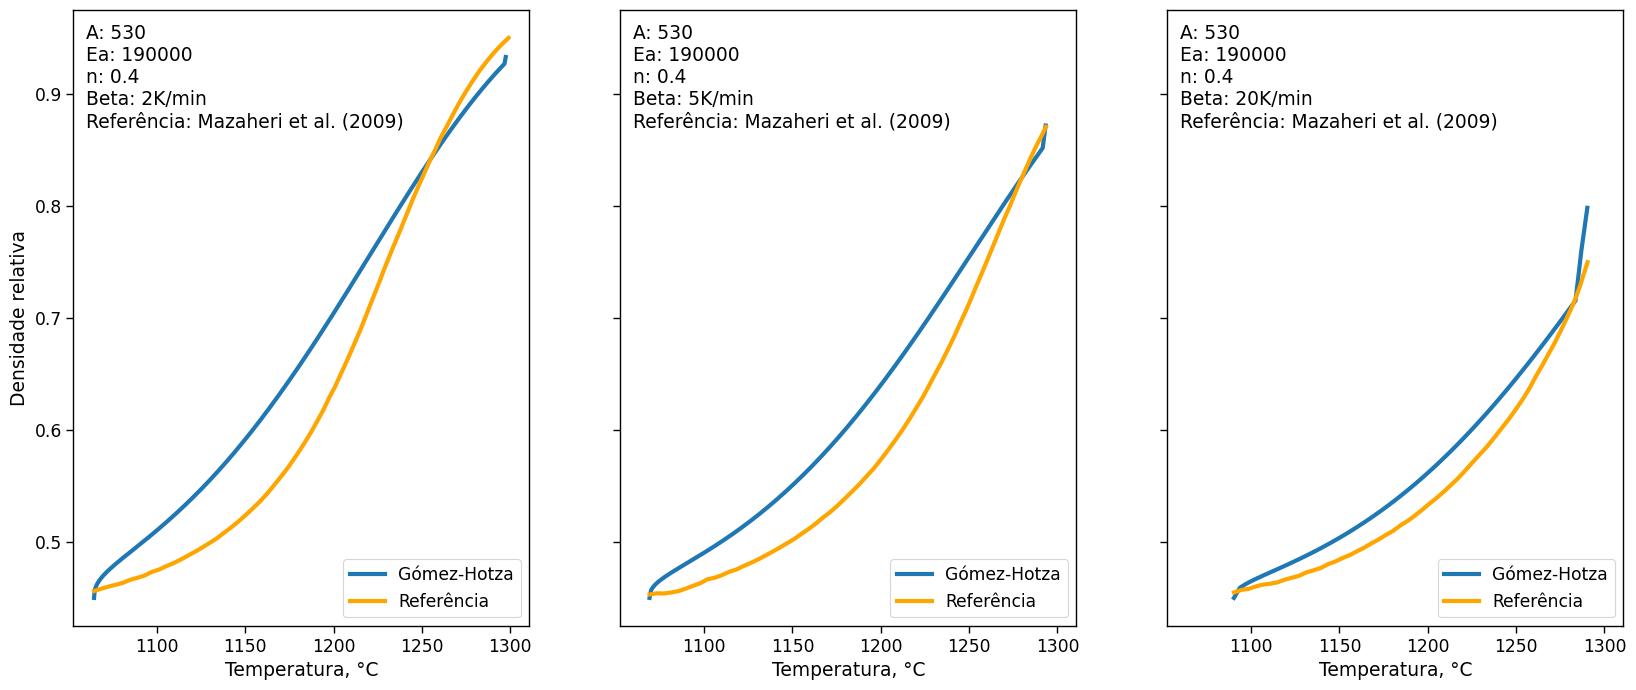

In [99]:
fig, axs = plt.subplots(ncols = 3, figsize = (20, 8), sharex=True, sharey=True) 

sns.lineplot(data = ytzp2K, 
             x='temperatureC',
             y='density',
             label='Gómez-Hotza',
             ax = axs[0]
             )
sns.lineplot(data= mazaheri_2K,
             x='temperatureC',
             y='density',
             label='Referência',
             color='orange',
             ax = axs[0]
             )

sns.lineplot(data = ytzp5K, 
             x='temperatureC',
             y='density',
             label='Gómez-Hotza',
             ax = axs[1]
             )
sns.lineplot(data= mazaheri_5K,
             x='temperatureC',
             y='density',
             label='Referência',
             color='orange',
             ax = axs[1]
             )

sns.lineplot(data = ytzp20K, 
             x='temperatureC',
             y='density',
             label='Gómez-Hotza',
             ax = axs[2]
             )
sns.lineplot(data= mazaheri_20K,
             x='temperatureC',
             y='density',
             label='Referência',
             color='orange',
             ax = axs[2]
             )

axs[0].set_xlabel('Temperatura, °C')
axs[1].set_xlabel('Temperatura, °C')
axs[2].set_xlabel('Temperatura, °C')

axs[0].set_ylabel('Densidade relativa')

axs[0].text(1060, 0.87, 'A: 530\nEa: 190000\nn: 0.4\nBeta: 2K/min\nReferência: Mazaheri et al. (2009)')
axs[1].text(1060, 0.87,'A: 530\nEa: 190000\nn: 0.4\nBeta: 5K/min\nReferência: Mazaheri et al. (2009)')
axs[2].text(1060, 0.87, 'A: 530\nEa: 190000\nn: 0.4\nBeta: 20K/min\nReferência: Mazaheri et al. (2009)')

axs[0].legend(loc='lower right')
axs[1].legend(loc='lower right')
axs[2].legend(loc='lower right')

plt.show()

In [46]:
params2, result2 = validation(A_values=np.arange(550, 600, 5), n_values=np.arange(0.1, 1.0, 0.1), Ea_values=np.arange(170e3, 220e3,500) , curves=mazaheri_list)
print(f'Best params: {params2}')
result2

Best params: {'A': 595, 'Ea': 191500.0, 'n': 0.4, 'Mean RMSE': 0.03378023768207194}


,A,Ea,n,RMSE1,RMSE2,RMSE3,sum_of_errors,mean_RMSE
0,550,170000.0,0.1,0.207706,0.163325,0.107465,0.478495,0.159498
1,550,170000.0,0.2,0.083804,0.071061,0.051137,0.206002,0.068667
2,550,170000.0,0.3,0.130159,0.118707,0.081945,0.330812,0.110271
3,550,170000.0,0.4,0.268464,0.264111,0.214648,0.747223,0.249074
4,550,170000.0,0.5,0.337149,0.347604,0.321643,1.006395,0.335465
...,...,...,...,...,...,...,...,...
8995,595,219500.0,0.5,0.144159,0.139255,0.111616,0.395030,0.131677
8996,595,219500.0,0.6,0.027618,0.065021,0.087032,0.179672,0.059891
8997,595,219500.0,0.7,0.106455,0.050366,0.042237,0.199058,0.066353
8998,595,219500.0,0.8,0.209181,0.165418,0.031543,0.406143,0.135381


In [47]:
result2.sort_values('mean_RMSE').head()

,A,Ea,n,RMSE1,RMSE2,RMSE3,sum_of_errors,mean_RMSE
8490,595,191500.0,0.4,0.032128,0.028471,0.040742,0.101341,0.033780
7590,590,191500.0,0.4,0.031477,0.028718,0.041330,0.101525,0.033842
5781,580,191000.0,0.4,0.033733,0.028249,0.039560,0.101543,0.033848
4881,575,191000.0,0.4,0.032993,0.028408,0.040161,0.101562,0.033854
6681,585,191000.0,0.4,0.034501,0.028139,0.038966,0.101606,0.033869


In [57]:
display(result2.head(1))
display(result2.tail(1))

,A,Ea,n,RMSE1,RMSE2,RMSE3,sum_of_errors,mean_RMSE
0,550,170000.0,0.1,0.207706,0.163325,0.107465,0.478495,0.159498


,A,Ea,n,RMSE1,RMSE2,RMSE3,sum_of_errors,mean_RMSE
8999,595,219500.0,0.9,0.277988,0.252092,0.124043,0.654123,0.218041


In [48]:
ytzp2K = gomez_hotza(Tmax=1298.94, Tinit=1064.38, beta=2, n=0.4, A=595, Ea=191500, G=7.5e-8, theta0=0.55, total_time=7e3, dt=10, as_df=True)
ytzp5K = gomez_hotza(Tmax=1293.494162, Tinit=1069.159506, beta=5, n=0.4,A=595, Ea=191500, G=7.5e-8, theta0=0.55, total_time=2.7e3, dt=10, as_df=True)
ytzp20K = gomez_hotza(Tmax=1290.4257545714916, Tinit=1090.2974223397223, beta=20, n=0.4, A=595, Ea=191500, G=7.5e-8, theta0=0.55, total_time=6.1e2, dt=10, as_df=True)

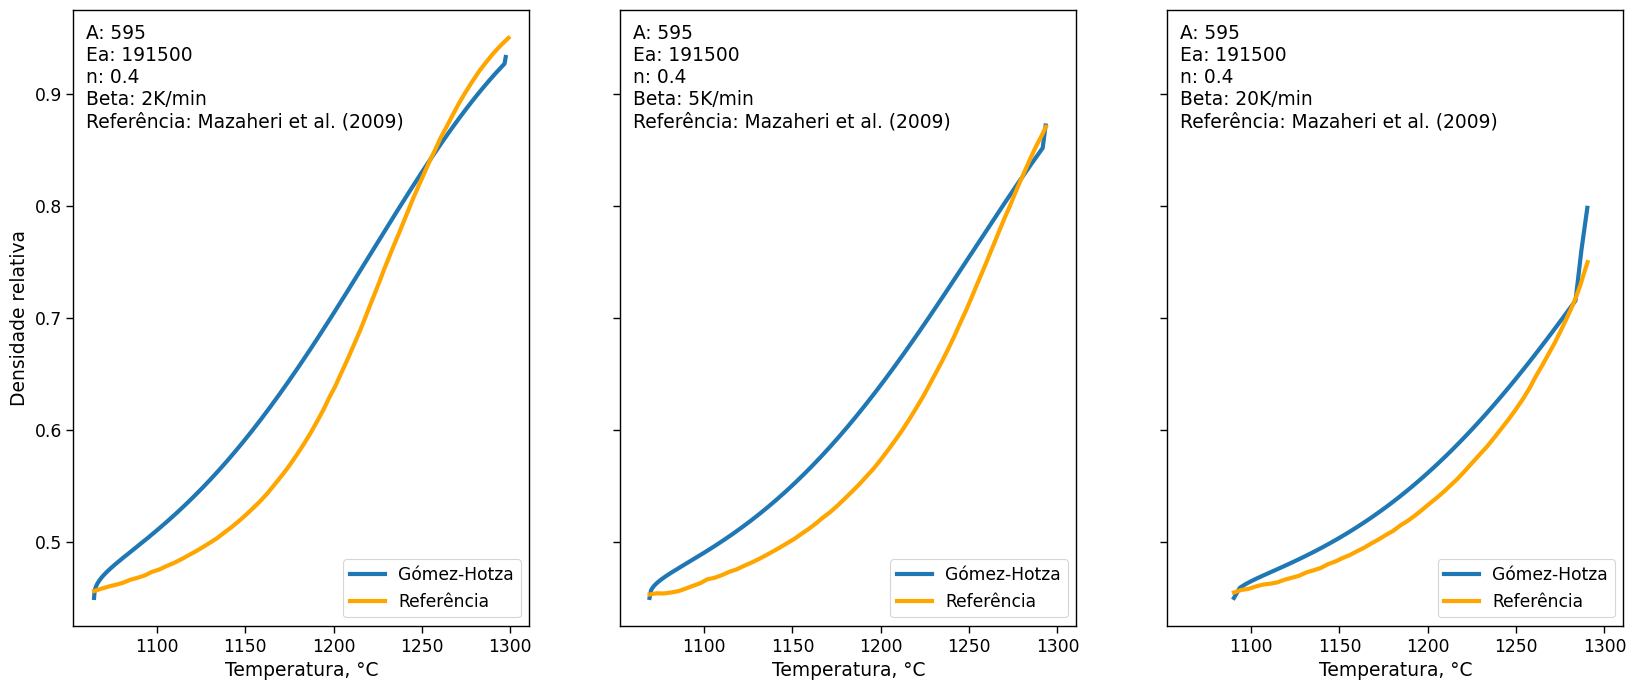

In [100]:
fig, axs = plt.subplots(ncols = 3, figsize = (20, 8), sharex=True, sharey=True) 

sns.lineplot(data = ytzp2K, 
             x='temperatureC',
             y='density',
             label='Gómez-Hotza',
             ax = axs[0]
             )
sns.lineplot(data= mazaheri_2K,
             x='temperatureC',
             y='density',
             label='Referência',
             color='orange',
             ax = axs[0]
             )

sns.lineplot(data = ytzp5K, 
             x='temperatureC',
             y='density',
             label='Gómez-Hotza',
             ax = axs[1]
             )
sns.lineplot(data= mazaheri_5K,
             x='temperatureC',
             y='density',
             label='Referência',
             color='orange',
             ax = axs[1]
             )

sns.lineplot(data = ytzp20K, 
             x='temperatureC',
             y='density',
             label='Gómez-Hotza',
             ax = axs[2]
             )
sns.lineplot(data= mazaheri_20K,
             x='temperatureC',
             y='density',
             label='Referência',
             color='orange',
             ax = axs[2]
             )

axs[0].set_xlabel('Temperatura, °C')
axs[1].set_xlabel('Temperatura, °C')
axs[2].set_xlabel('Temperatura, °C')

axs[0].set_ylabel('Densidade relativa')

axs[0].text(1060, 0.87, 'A: 595\nEa: 191500\nn: 0.4\nBeta: 2K/min\nReferência: Mazaheri et al. (2009)')
axs[1].text(1060, 0.87, 'A: 595\nEa: 191500\nn: 0.4\nBeta: 5K/min\nReferência: Mazaheri et al. (2009)')
axs[2].text(1060, 0.87, 'A: 595\nEa: 191500\nn: 0.4\nBeta: 20K/min\nReferência: Mazaheri et al. (2009)')

axs[0].legend(loc='lower right')
axs[1].legend(loc='lower right')
axs[2].legend(loc='lower right')
plt.show()

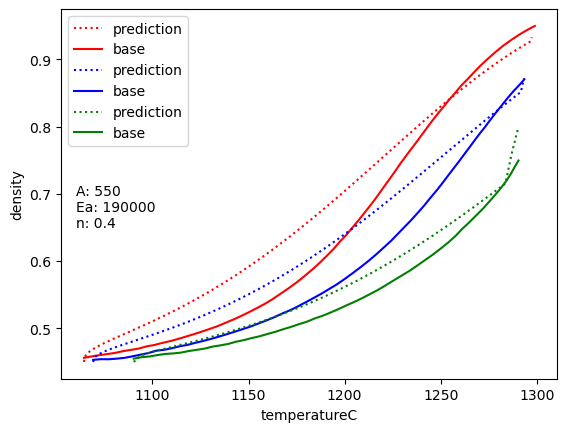

In [50]:
sns.lineplot(data = ytzp2K, 
             x='temperatureC',
             y='density',
             label='prediction',
             color='red',
             linestyle=':')
sns.lineplot(data= mazaheri_2K,
             x='temperatureC',
             y='density',
             label='base',
             color = 'red'
             )

sns.lineplot(data = ytzp5K, 
             x='temperatureC',
             y='density',
             label='prediction',
             color='blue',
             linestyle=':'
             )
sns.lineplot(data= mazaheri_5K,
             x='temperatureC',
             y='density',
             label='base',
             color = 'blue'
             )

sns.lineplot(data = ytzp20K, 
             x='temperatureC',
             y='density',
             label='prediction',
             color='green',
             linestyle=':'
             )
sns.lineplot(data= mazaheri_20K,
             x='temperatureC',
             y='density',
             label='base',
             color='green'
             )

plt.text(1060, 0.65, 'A: 550\nEa: 190000\nn: 0.4')

plt.show()

In [51]:
duran = read_clean_csv("C:/Users/gupau/Documents/UFSC - PC/Semestre 23.2/TCC/Duran/duran.csv", double_headed=False)

In [52]:
duran_dict = {'df': duran, 'G': 10e-9, 'theta0':0.596372, 'beta':5.0, 'beta_SI':False, 'Xaxis': 'temperatureC', 'Yaxis':'density'}

In [53]:
duran

,temperatureC,density
0,406.415520,0.403628
1,559.801603,0.405310
2,675.883820,0.416553
3,771.797220,0.431607
4,856.682085,0.467877
5,928.509404,0.522139
6,961.952309,0.564715
7,986.324226,0.610486
8,1043.116964,0.694967
9,1070.565957,0.755552


In [54]:
params3, result3 = validation(A_values=[595], Ea_values=[191500.0], n_values=[0.4], curves=[duran_dict])
RMSE_duran = params3['Mean RMSE']
print(f'Best RMSE: {RMSE_duran}')

Best RMSE: 0.14821442611765553


In [55]:
duran_predict = gomez_hotza(Tmax=1386.220718, Tinit=406.415520, beta=5, n=0.4, A=595, Ea=191500, G=10e-9, theta0=0.596372, total_time=7e4, dt=10, as_df=True)
duran_predict

,time,temperatureK,density,porosity,time_min,temperatureC
0,0.0,679.415520,0.403628,0.596372,0.000000,406.415520
1,10.0,680.248853,0.403628,0.596372,0.166667,407.248853
2,20.0,681.082187,0.403628,0.596372,0.333333,408.082187
3,30.0,681.915520,0.403628,0.596372,0.500000,408.915520
4,40.0,682.748853,0.403628,0.596372,0.666667,409.748853
...,...,...,...,...,...,...
6995,69950.0,1659.220718,1.000000,0.000000,1165.833333,1386.220718
6996,69960.0,1659.220718,1.000000,0.000000,1166.000000,1386.220718
6997,69970.0,1659.220718,1.000000,0.000000,1166.166667,1386.220718
6998,69980.0,1659.220718,1.000000,0.000000,1166.333333,1386.220718


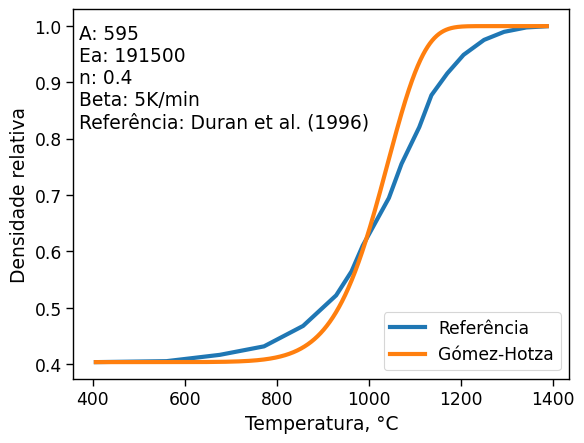

In [102]:
sns.lineplot(data = duran, 
             x='temperatureC',
             y='density',
             label='Referência'
             )
sns.lineplot(data= duran_predict,
             x='temperatureC',
             y='density',
             label='Gómez-Hotza'
             )
plt.xlabel('Temperatura, °C')
plt.ylabel('Densidade relativa')

plt.legend(loc='lower right')
plt.text(370, 0.82, 'A: 595\nEa: 191500\nn: 0.4\nBeta: 5K/min\nReferência: Duran et al. (1996)')
plt.show()